In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras

In [2]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)


1065301781/1065301781 [==============================] - 12s 0us/step


In [3]:
from pathlib import Path

quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [5]:
train_files

['/root/.keras/datasets/quickdraw/training.tfrecord-00000-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00001-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00002-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00003-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00004-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00005-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00006-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00007-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00008-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00009-of-00010']

In [4]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()

with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [6]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [7]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [8]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [9]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [10]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [66]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[-0.06666669  0.00892858  0.        ]
  [-0.01568627 -0.03571428  0.        ]
  [-0.00784314 -0.11160715  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.13445377 -0.02745098  0.        ]
  [-0.27731094  0.          0.        ]
  [-0.12605041  0.06666667  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.          0.          1.        ]
  [-0.14141414  0.01960784  0.        ]
  [ 0.0050505  -0.01568627  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[-0.01568628  0.12280703  0.        ]
  [-0.01176471  0.00877193  0.        ]
  [-0.00784314  0.14035086  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

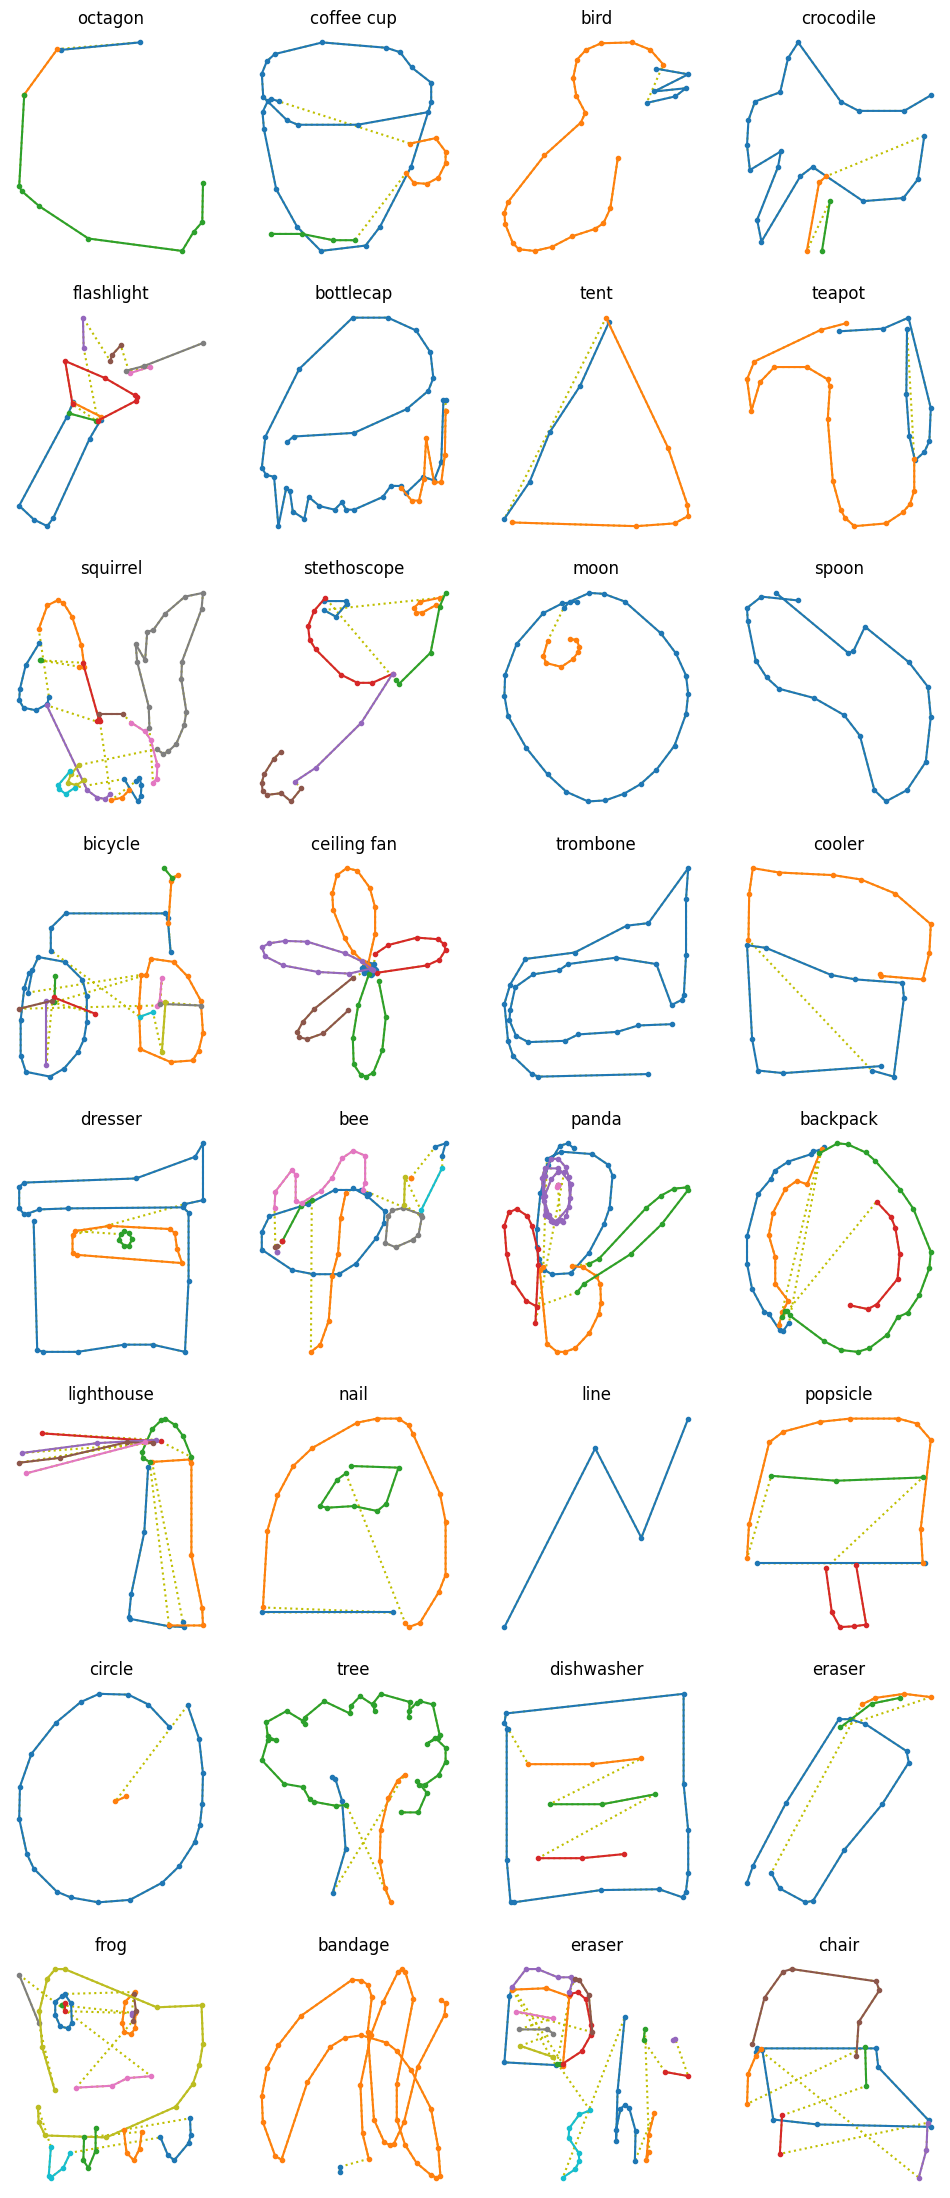

In [12]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

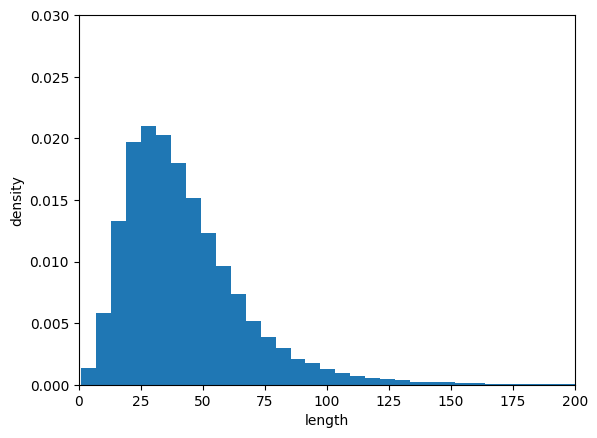

In [13]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [14]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [15]:
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, BatchNormalization, Dropout, Bidirectional, LSTM, Dense, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_1 = Sequential([
    Conv1D(32, kernel_size=5, strides=2, activation="relu",input_shape = (100,3)),
    BatchNormalization(),
    Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    BatchNormalization(),
    Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Bidirectional(LSTM(256, return_sequences=True)),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(len(class_names), activation="softmax")
])

model_1.load_weights("/content/sketch_rnn_weights.h5")
optimizer = keras.optimizers.Adam(learning_rate=1e-3, clipnorm = 1.)

model_1.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])

# Setup EarlyStopping and ModelCheckpoint callbacks
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy')
model_checkpoint_cb = ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_accuracy')

# Train the model with both callbacks
history_1 = model_1.fit(cropped_train_set, epochs= 8,
                    validation_data=cropped_valid_set,
                    callbacks=[early_stopping_cb, model_checkpoint_cb])

model_1.summary()

Epoch 1/8
107813/107813 [==============================] - 2038s 19ms/step - loss: 2.1289 - accuracy: 0.5007 - sparse_top_k_categorical_accuracy: 0.7697 - val_loss: 1.6357 - val_accuracy: 0.5965 - val_sparse_top_k_categorical_accuracy: 0.8448
Epoch 2/8


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


107813/107813 [==============================] - 2078s 19ms/step - loss: 2.0266 - accuracy: 0.5231 - sparse_top_k_categorical_accuracy: 0.7856 - val_loss: 1.5823 - val_accuracy: 0.6094 - val_sparse_top_k_categorical_accuracy: 0.8514
Epoch 3/8
107813/107813 [==============================] - 2096s 19ms/step - loss: 1.9623 - accuracy: 0.5375 - sparse_top_k_categorical_accuracy: 0.7955 - val_loss: 1.5365 - val_accuracy: 0.6198 - val_sparse_top_k_categorical_accuracy: 0.8586
Epoch 4/8
107813/107813 [==============================] - 2056s 19ms/step - loss: 1.9183 - accuracy: 0.5476 - sparse_top_k_categorical_accuracy: 0.8019 - val_loss: 1.5135 - val_accuracy: 0.6264 - val_sparse_top_k_categorical_accuracy: 0.8621
Epoch 5/8
107813/107813 [==============================] - 2102s 19ms/step - loss: 1.8836 - accuracy: 0.5550 - sparse_top_k_categorical_accuracy: 0.8073 - val_loss: 1.4956 - val_accuracy: 0.6319 - val_sparse_top_k_categorical_accuracy: 0.8651
Epoch 6/8
107813/107813 [=============

In [ ]:
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define your model
model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation="softmax")
])

optimizer = keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])

# Setup EarlyStopping callback
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy')

# Train the model with both callbacks
history = model.fit(cropped_train_set, epochs=10,
                    validation_data=cropped_valid_set,
                    callbacks=[early_stopping_cb])

Epoch 1/10
107813/107813 [==============================] - 1307s 12ms/step - loss: 4.0742 - accuracy: 0.1712 - sparse_top_k_categorical_accuracy: 0.3765 - val_loss: 3.1033 - val_accuracy: 0.3046 - val_sparse_top_k_categorical_accuracy: 0.5891
Epoch 2/10
107813/107813 [==============================] - 1303s 12ms/step - loss: 2.6939 - accuracy: 0.3803 - sparse_top_k_categorical_accuracy: 0.6711 - val_loss: 2.4817 - val_accuracy: 0.4184 - val_sparse_top_k_categorical_accuracy: 0.7106
Epoch 3/10
107813/107813 [==============================] - 1258s 12ms/step - loss: 2.3203 - accuracy: 0.4525 - sparse_top_k_categorical_accuracy: 0.7392 - val_loss: 2.2008 - val_accuracy: 0.4766 - val_sparse_top_k_categorical_accuracy: 0.7593
Epoch 4/10
107813/107813 [==============================] - 1265s 12ms/step - loss: 2.1234 - accuracy: 0.4927 - sparse_top_k_categorical_accuracy: 0.7723 - val_loss: 2.0464 - val_accuracy: 0.5081 - val_sparse_top_k_categorical_accuracy: 0.7847
Epoch 5/10
107813/107813

In [67]:
def sketches_transform(sketches):
  resized_sketches = []
  for sketch in sketches:
    resized_sketch = tf.image.resize(tf.expand_dims(sketch, axis=-1), size=(100, 3))
    resized_sketches.append(resized_sketch)
  tensor_of_sketches = tf.stack(resized_sketches)
  tensor_of_sketches = tf.reshape(tensor_of_sketches, (-1, 100, 3))
  return tensor_of_sketches
t_sketches = sketches_transform(sketches)

In [68]:
sketches.shape

TensorShape([32, 145, 3])

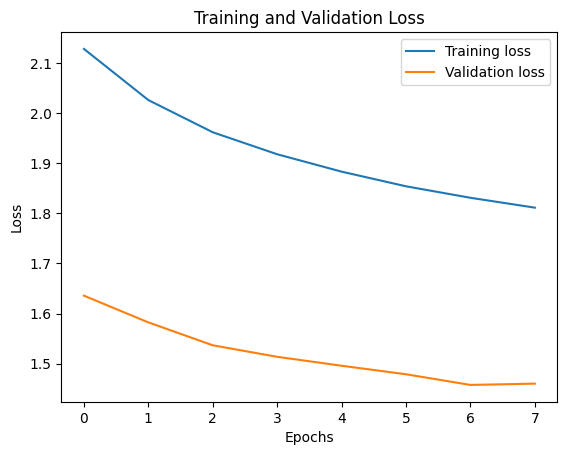

In [19]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

plot_loss(history_1)

In [20]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model_1.predict(test_set)

5392/5392 [==============================] - 51s 9ms/step


In [21]:
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

0.85936195

1/1 [==============================] - 0s 20ms/step


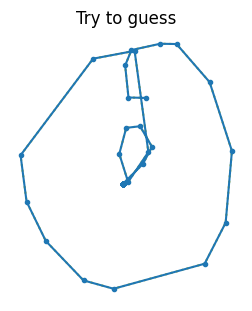

Top-5 predictions:
  1. mouse 21.107%
  2. frying pan 11.162%
  3. pond 6.903%
  4. garden hose 5.193%
  5. paper clip 3.346%
Answer: flower


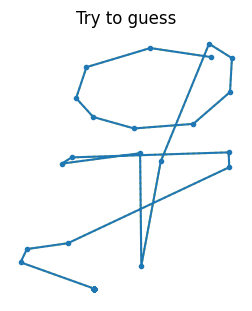

Top-5 predictions:
  1. yoga 51.411%
  2. floor lamp 4.119%
  3. shovel 3.554%
  4. nail 3.271%
  5. microphone 3.096%
Answer: yoga


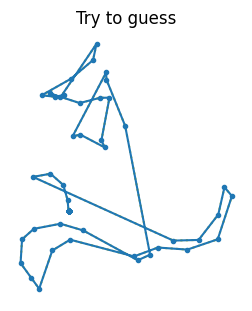

Top-5 predictions:
  1. kangaroo 97.581%
  2. giraffe 0.636%
  3. flamingo 0.338%
  4. mermaid 0.169%
  5. duck 0.153%
Answer: kangaroo


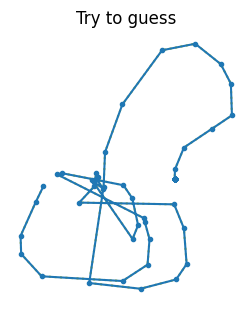

Top-5 predictions:
  1. mouse 16.755%
  2. yoga 7.763%
  3. frog 4.627%
  4. mosquito 4.360%
  5. snowman 3.346%
Answer: purse


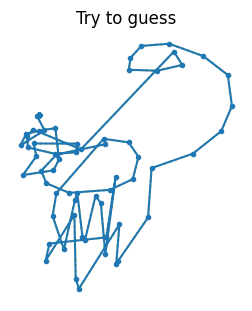

Top-5 predictions:
  1. animal migration 15.725%
  2. rain 14.129%
  3. ant 11.683%
  4. scorpion 6.020%
  5. peas 3.694%
Answer: scorpion


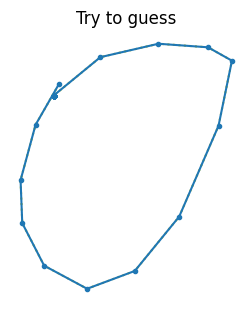

Top-5 predictions:
  1. hexagon 27.817%
  2. octagon 14.882%
  3. canoe 7.718%
  4. string bean 5.888%
  5. hockey puck 3.057%
Answer: table


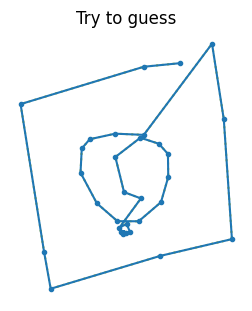

Top-5 predictions:
  1. power outlet 61.425%
  2. traffic light 10.420%
  3. washing machine 6.911%
  4. stereo 3.393%
  5. streetlight 2.342%
Answer: power outlet


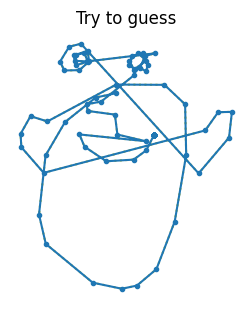

Top-5 predictions:
  1. face 31.796%
  2. monkey 11.611%
  3. owl 10.525%
  4. panda 10.467%
  5. smiley face 4.548%
Answer: face


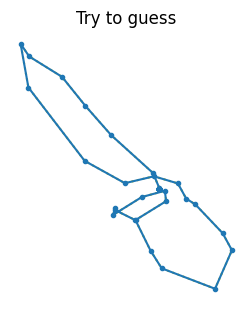

Top-5 predictions:
  1. sword 68.827%
  2. knife 9.316%
  3. screwdriver 6.986%
  4. syringe 4.897%
  5. shovel 1.476%
Answer: screwdriver


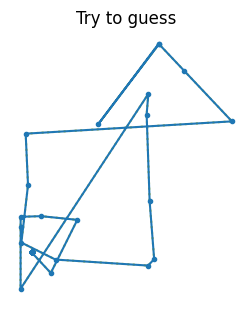

Top-5 predictions:
  1. syringe 53.520%
  2. church 8.364%
  3. screwdriver 4.987%
  4. flashlight 1.477%
  5. toothpaste 1.326%
Answer: barn


In [69]:
n_new = 10
Y_probas = model_1.predict(t_sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(t_sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))

In [18]:
weights_file = "sketch_rnn_weights_1.h5"  # H5 format
model_1.save_weights(weights_file)